# Deep-TDA : Deep Targeted Discriminant Analysis
Reference paper: _Trizio and Parrinello, [JPCL](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.1c02317) (2021)_ [[arXiv]](https://128.84.4.34/abs/2107.05444). 

#### Introduction
The Deep Targeted Discriminant Analysis (DeepTDA) is a method for the supervised learning of discriminant-based collective variables (CVs) starting from information limited to the $N_s$ metastable states only.

In DeepTDA a Neural Network (NN) is used to map a high-dimensional set of descriptors $\mathbf{s}$, collected in the metastable states, into a low-dimensional CV space $\mathbf{s}$. The NN is trained so that the data from each metastable state, when projected along the CV, are distributed according to a preassigned target in which the different states are well-defined. In the practice, this target is taken as a sum of Nm of Gaussians, one for each state in the system

<center><img src="images/deepTDAscheme.png" width="500" /></center>


##### Optimization criterion
Each state $k$ thus contributes two terms for each dimension $\rho$ of the CVs space $\mathbf{s}$ to the loss function which has to be minimized during the training of the model. 

$$L^\mu_{k,\rho} = (\mu_{k,\rho} - \mu^{tg}_{k,\rho})^2 \qquad L^\sigma_{k,\rho} = (\sigma_{k,\rho} - \sigma^{tg}_{k,\rho})^2$$

The term $L^\mu_{k,\rho}$ enfroces the position of the center $\mu$ of the distribution of data from state $k$ along the dimension $\rho$ to match the target one $\mu^tg$. The second term $L^\sigma_{k,\rho}$ does the same thing for the width of the distribution, defined as the standard deviation.

The total loss function is obtained by summing over the $N_s$ states $k$ and the $N_d$ dimension $\rho$ of the CVs space:

$$ L_{TDA} = \sum_\rho^{N_d} \sum_k^{N_s} [\alpha L^\mu_{k,\rho} + \beta L^\sigma_{k,\rho}] $$ 

Where $\alpha$ and $\beta$ hyperparameters are used to balance the center and width contributions to the loss to roughly the same magnitude in the first stage of the training.

##### Choice of the target

**Fast most-of-the-times recipe**:
- `target_centers` : The Gaussians associated to different metastable states should be placed in a way such that the distance with respect to other Gaussians is at least around 10/20 au. *For example* $\mu_A =-7, \mu_B=7$  
- `target_sigmas` : Widths of the order of 0.2/0.5 should be fine most of the time.

**Rationale behind** :
In order to get an effective DeepTDA CV the Gaussians associated to the different states must be:
- **Not too close to each other** otherwise the there would not be enough space in between for the transition state (on which typically one has very limited information)
- **Not too far each other** otherwise most of the CV space would require the NN to extrapolate rather than to interpolate from the provided data.
- **Not too narrow**, besides being unphysical this would also lead to a very strong dependence on the atomic positions, which is better to be avoided in a biasing context as it would result in very strong forces
- **Not too wide**, besides being unphysical this would also lead to a very weak dependence on the atomic positions, which is better to be avoided in a biasing context as it would result in very small forces

# Import

In [1]:
# IMPORT PACKAGES
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcvs.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/etrizio/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Two-state

### Load MD data
We will use the two-state Muller-Brown potential as first example using `p.x` and `p.y` as descriptors.

In [2]:
from mlcvs.utils.io import create_dataset_from_files
from mlcvs.data import DictionaryDataModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)

 - Loaded dataframe (4002, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


DictionaryDataModule(dataset -> DictionaryDataset( "data": [4002, 2], "labels": [4002] ),
		     train_loader -> FastDictionaryLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> FastDictionaryLoader(length=0.2, batch_size=0, shuffle=True))

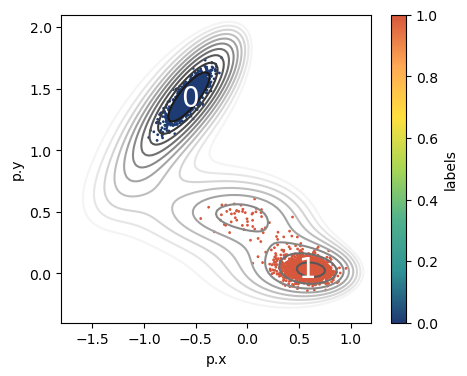

In [3]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Define model

In [4]:
from mlcvs.cvs import DeepTDA

n_components = n_states-1
nn_layers = [2,128,64,1]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
# MODEL
model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=[-7,7], target_sigmas=[0.2, 0.2], layers=nn_layers, options=options)

#### Define Trainer & Fit

In [5]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-3, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/home/etrizio/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

/home/etrizio/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 256: 100%|██████████| 1/1 [00:00<00:00, 22.83it/s, v_num=4] 


Learning curve

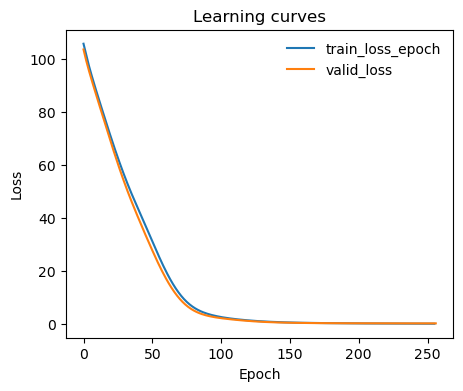

In [6]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Analysis of the CV

CVs isolines

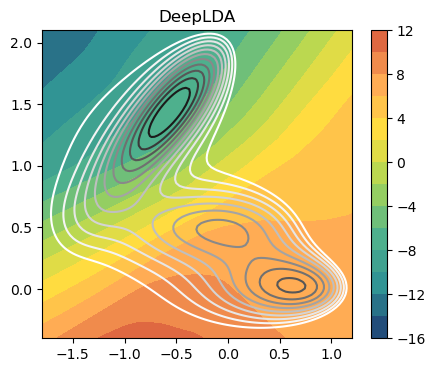

In [7]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('DeepTDA')
plt.show()

CVs histogram

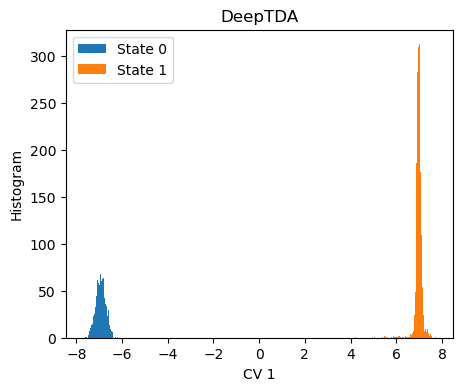

In [8]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV {i}')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

# Multi-state

### Load MD data
We will use a modified three-state Muller-Brown potential as multi-state example using `p.x` and `p.y` as descriptors.

In [9]:

n_states = 3
filenames = [ f"data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)
Class 2 dataframe shape:  (2001, 13)

 - Loaded dataframe (6003, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (6003, 2): ['p.x', 'p.y']


DictionaryDataModule(dataset -> DictionaryDataset( "data": [6003, 2], "labels": [6003] ),
		     train_loader -> FastDictionaryLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> FastDictionaryLoader(length=0.2, batch_size=0, shuffle=True))

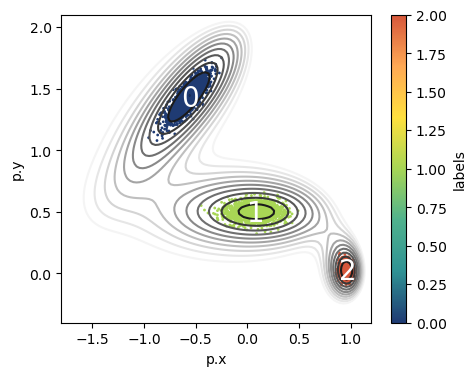

In [10]:
from mlcvs.utils.plot import muller_brown_potential_three_states

fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Define model

In [20]:
from mlcvs.cvs import DeepTDA

nn_layers = [2,128,64,2]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
# MODEL
model = DeepTDA(n_states=n_states, 
                n_cvs=2,
                target_centers=[[-4,-5], [0,5] ,[4, -5]], 
                target_sigmas=[[0.2, 0.2], [0.2, 0.2], [0.2, 0.2]],
                layers=nn_layers, 
                options=options)

#### Define Trainer & Fit

In [21]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="train_loss", mode='min', min_delta=1e-1, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | nn      | FeedForward   | 8.8 K  | [2]      | [2]      
-----------------------------------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


/home/etrizio/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 222: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s, v_num=8]


Learning curve

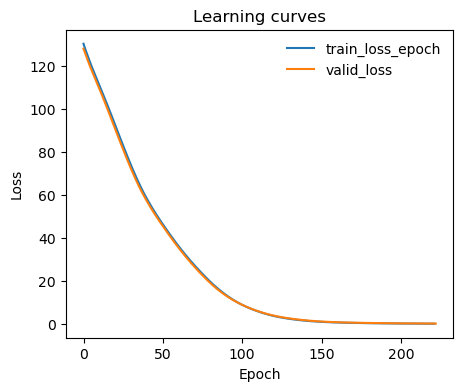

In [22]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Analysis of the CV

CVs isolines

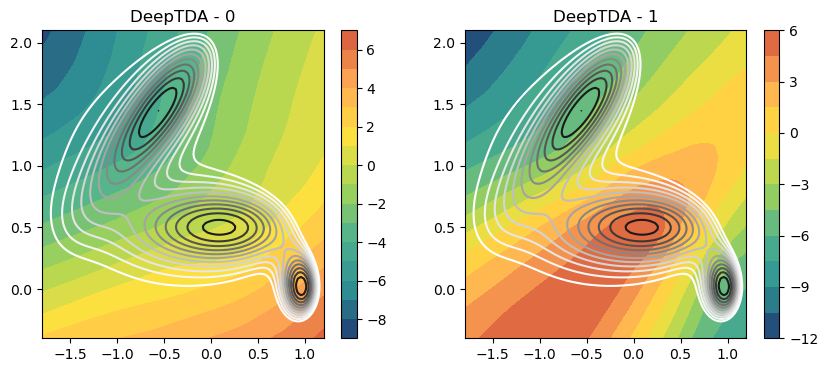

In [27]:
fig,axs = plt.subplots( 1, 2, figsize=(10,4) )
for i in range(2):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=15, ax=ax)
    ax.set_title(f'DeepTDA - {i}')
plt.show()

CVs histogram

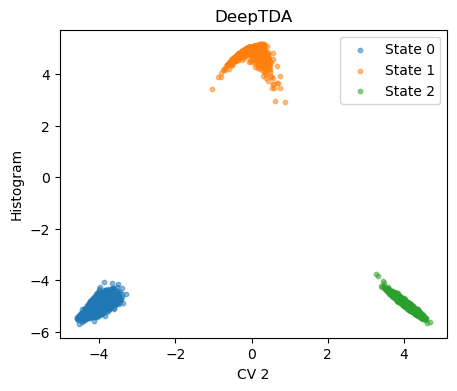

In [33]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.scatter(s_red[:, 0], s_red[:,1], label=f'State {i}', alpha=0.5, s=10)

ax.set_xlabel(f'CV {i}')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

# Multi-state reduced

### Load MD data
We will use a modified three-state Muller-Brown potential as multi-state example using `p.x` and `p.y` as descriptors.

In [ ]:

n_states = 3
filenames = [ f"data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictionaryDataModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)
Class 2 dataframe shape:  (2001, 13)

 - Loaded dataframe (6003, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (6003, 2): ['p.x', 'p.y']


DictionaryDataModule(dataset -> DictionaryDataset( "data": [6003, 2], "labels": [6003] ),
		     train_loader -> FastDictionaryLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> FastDictionaryLoader(length=0.2, batch_size=0, shuffle=True))

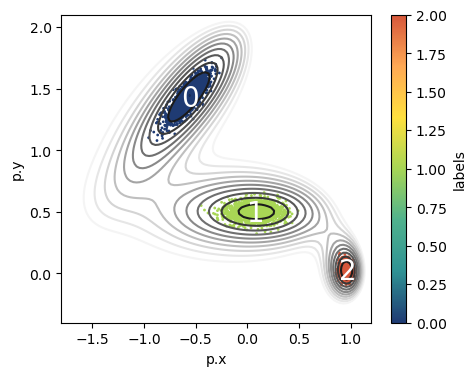

In [ ]:
from mlcvs.utils.plot import muller_brown_potential_three_states

fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')


### Define model

In [ ]:
from mlcvs.cvs import DeepTDA

n_components = 1
nn_layers = [2,128,64,1]
nn_args = {'activation': 'relu'}
options= {'nn': nn_args}
# MODEL
model = DeepTDA(n_states=n_states, n_cvs=1,target_centers=[-14,0,14], target_sigmas=[0.2, 0.2, 0.2], layers=nn_layers, options=options)

#### Define Trainer & Fit

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from mlcvs.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="train_loss", mode='min', min_delta=1e-1, patience=20)

# define trainer
trainer = pl.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=None, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | norm_in | Normalization | 0      | [2]      | [2]      
1 | nn      | FeedForward   | 8.7 K  | [2]      | [1]      
-----------------------------------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)


Epoch 629: 100%|██████████| 1/1 [00:00<00:00, 13.64it/s, v_num=7]          


Learning curve

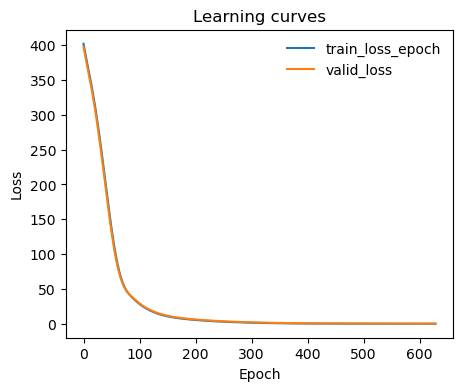

In [ ]:
ax = plot_metrics(metrics.metrics, 
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  yscale='linear')

#### Analysis of the CV

CVs isolines

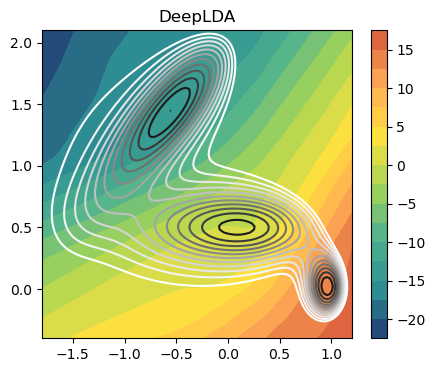

In [ ]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('DeepTDA')
plt.show()

CVs histogram

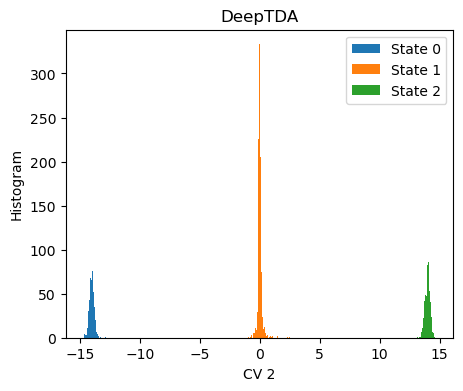

In [ ]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV {i}')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()